# Objective and Summary

This part aims at discovering if feature engineering helps to model improvement. 

1. Analysed the correlation between variables, reduced the number of variables from 46 to 19.
   Coefficient for categorical data -- Cramer'V

2. Convert continuous data to categorical data which showed clearer linear relation between  predictors and target variable.

3. Permutation Feature Importance to avoid bias

4. Upsampling for more models -- a brief experiment 

In [2]:
import os
for dirname, _, filename in os.walk('/Documents/Excercise'):
    for file in filename:
        print(os.path.join(dirname, file))
        
        
#list all file under the path

In [216]:
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.preprocessing import LabelEncoder
from scipy.stats import chisquare
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,recall_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from eli5.sklearn import PermutationImportance


from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


import eli5
import plotly
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline
import seaborn as sns
sns.set()

   

In [217]:
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier, SGDClassifier, LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.naive_bayes import MultinomialNB

from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier


In [339]:
df = pd.read_csv('/Users/hengzizhao/Documents/Excercise/Telco_customer_churn.csv')


In [7]:
df.columns

Index(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges', 'Churn Label', 'Churn Value',
       'Churn Score', 'CLTV', 'Churn Reason'],
      dtype='object')

The last 5 variables contain exit interview information and should not be included for prediction. Having an exit interview means someone has churned, this 'forward-looking' information needs to be avoid.

In [254]:
df.drop(['Churn Label','Churn Score','CLTV','Churn Reason'],axis= 1, inplace= True)

In [220]:
df.describe(include=[object]).loc['unique']

#variables only having 1 value are not useful, should remove.

CustomerID           7043
Country                 1
State                   1
City                 1129
Lat Long             1652
Gender                  2
Senior Citizen          2
Partner                 2
Dependents              2
Phone Service           2
Multiple Lines          3
Internet Service        3
Online Security         3
Online Backup           3
Device Protection       3
Tech Support            3
Streaming TV            3
Streaming Movies        3
Contract                3
Paperless Billing       2
Payment Method          4
Total Charges        6531
Name: unique, dtype: object

Count is a flag variable, the customers are all from California, but City has 1129 values, may be useful.

In [255]:
df.drop(['CustomerID','Count','Country','State','Lat Long','City','Zip Code','Latitude','Longitude'], axis=1, inplace= True)  

#CustomerID is also not useful, lat long is duplicated information

These variables may not be useful, lat long is duplicated information

In [222]:
#list relevant categorical variables 

col_name = df.describe(include=[object]).columns.to_list()


In [223]:
# check each variable value except for 'City' and 'Total Charges'
print('=============Unique Value for Categorical Data========================')
print(*('{}:{}'.format(i, df[i].unique()) for i in col_name[1:-1]),sep='\n') 

=============Unique Value for Categorical Data========================
Senior Citizen:['No' 'Yes']
Partner:['No' 'Yes']
Dependents:['No' 'Yes']
Phone Service:['Yes' 'No']
Multiple Lines:['No' 'Yes' 'No phone service']
Internet Service:['DSL' 'Fiber optic' 'No']
Online Security:['Yes' 'No' 'No internet service']
Online Backup:['Yes' 'No' 'No internet service']
Device Protection:['No' 'Yes' 'No internet service']
Tech Support:['No' 'Yes' 'No internet service']
Streaming TV:['No' 'Yes' 'No internet service']
Streaming Movies:['No' 'Yes' 'No internet service']
Contract:['Month-to-month' 'Two year' 'One year']
Paperless Billing:['Yes' 'No']
Payment Method:['Mailed check' 'Electronic check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


In [256]:
# handling missing data, reformat the value of 'Total Charges'
df.loc[df['Total Charges']==' ', 'Total Charges'] = 0
df['Total Charges'] = pd.to_numeric(df['Total Charges'])
df['Total Charges'].dtype

dtype('float64')

# Exporatory data analysis
  Before encodeing the data for modelling, EDA should be conducted to get some insight and see what hypothsis we may   propose. Though this could be difficult for high dimetional data (computer version, NLP)

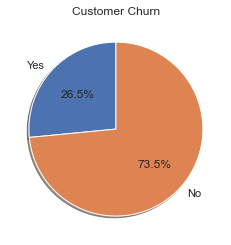

In [11]:

labels = 'Yes','No'
sizes = [len(df[df['Churn Value']==1])/len(df)*100,len(df[df['Churn Value']==0])/len(df)*100]


fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.set(aspect = 'equal',title = 'Customer Churn')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

# Imbalanced data

In [ ]:
#1. numeric variables and churn 
    Tenure
    Monthly charges
    Total charges

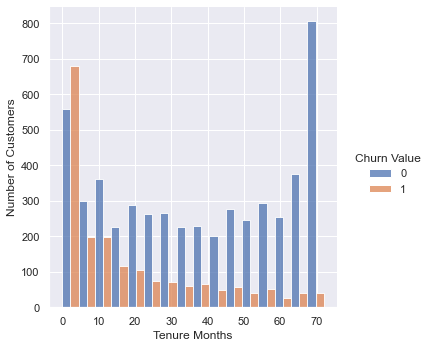

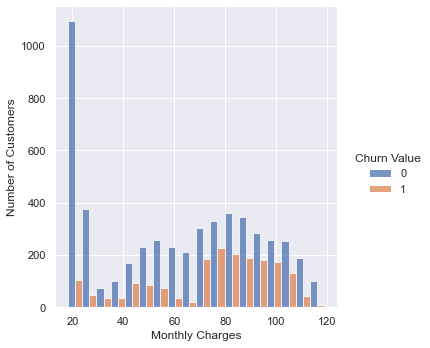

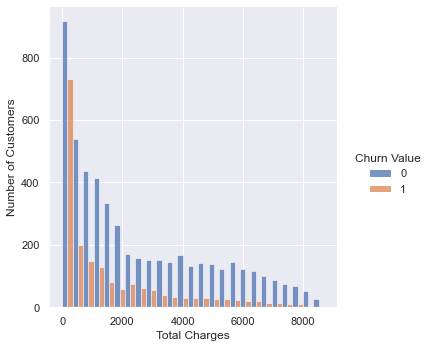

In [26]:
sns.set_theme()
sns.displot(df, x='Tenure Months', hue='Churn Value', multiple='dodge').set(ylabel='Number of Customers')
sns.displot(df, x='Monthly Charges', hue='Churn Value', multiple='dodge').set(xlabel='Monthly Charges', ylabel='Number of Customers')
sns.displot(df, x='Total Charges', hue='Churn Value', multiple='dodge').set(xlabel='Total Charges', ylabel='Number of Customers')

# 2. Some categorical variables 


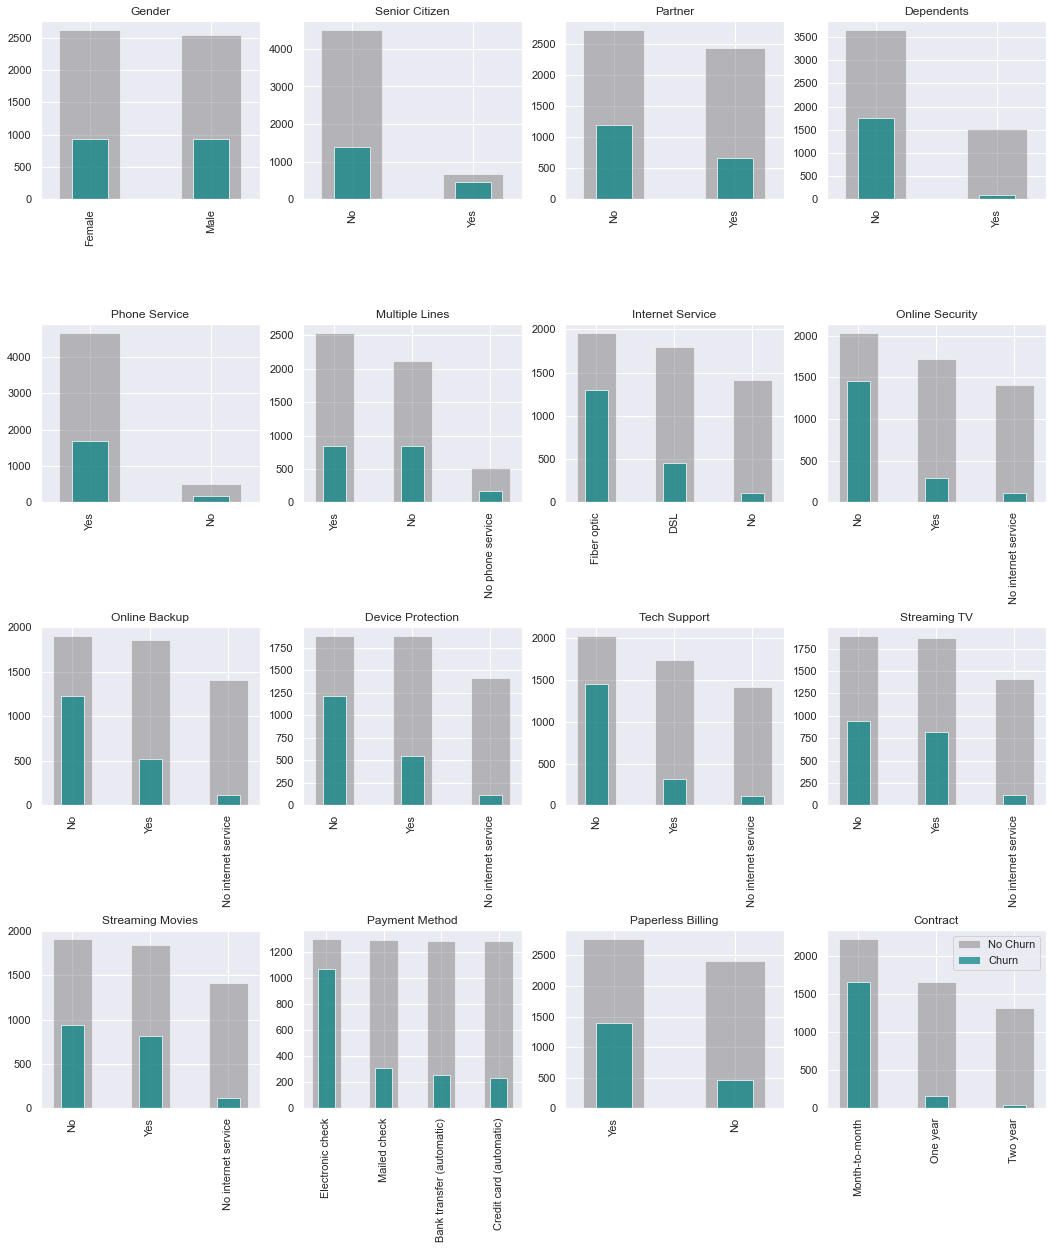

In [22]:
categorical_features = [
 'Gender',
 'Senior Citizen',
 'Partner',
 'Dependents',
 'Phone Service',
 'Multiple Lines',
 'Internet Service',
 'Online Security',
 'Online Backup',
 'Device Protection',
 'Tech Support',
 'Streaming TV',
 'Streaming Movies',
 'Payment Method',
 'Paperless Billing',
 'Contract' ]

ROWS, COLS = 4, 4
fig, ax = plt.subplots(ROWS, COLS, figsize=(18, 20) )
row, col = 0, 0
for i, categorical_feature in enumerate(categorical_features):
    if col == COLS - 1:
        row += 1
    col = i % COLS
    
    df[df['Churn Value']==0][categorical_feature].value_counts().plot(kind = 'bar', 
                width=.5, ax=ax[row, col], color='grey', alpha=0.5).set_title(categorical_feature)
    df[df['Churn Value']==1][categorical_feature].value_counts().plot(kind ='bar', 
                width=.3, ax=ax[row, col], color='teal', alpha=0.7).set_title(categorical_feature)
    plt.legend(['No Churn', 'Churn'])
    fig.subplots_adjust(hspace=0.7)
    
    # grey-> not churn
    # teal-> churn

# Observation

A good feature is when we can distinguish between churn and non-churn customers, gender doesn't deliver much information. Internet based services all have similar information gain.


For continuous variables, may be convert to categorical data.  

In [45]:
# change MonthlyCharges to categorical column
def nume2cato_split(ds,lst) :   
    if ds <= lst[0] :
        return 0
    elif (ds > lst[0]) & (ds <= lst[1] ):
        return 1
    elif (ds > lst[1]) & (ds <= lst[2] ):
        return 2
    elif ds > lst[2]:
        return 3
df['Total Charges'] = df['Total Charges'].apply(lambda x: nume2cato_split(x,[2000,4000,6000]))
df['Monthly Charges'] = df['Monthly Charges'].apply(lambda x: nume2cato_split(x,[30,70,99]))
df['Tenure Months'] = df['Tenure Months'].apply(lambda x: nume2cato_split(x,[20,40,60]))

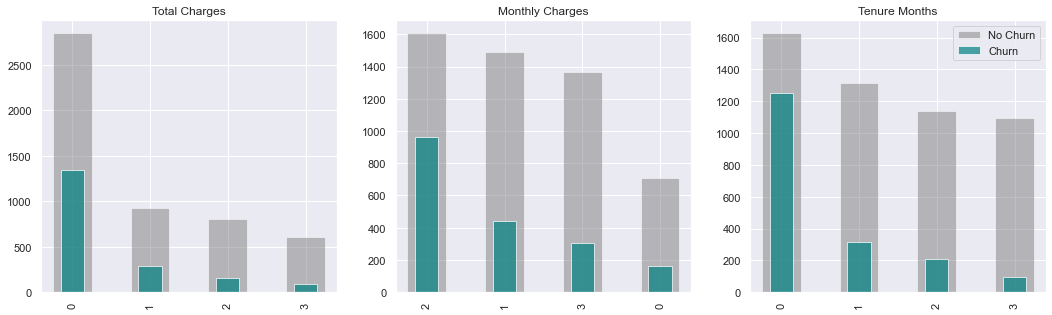

In [48]:
categorical_features = ['Total Charges','Monthly Charges','Tenure Months']

ROWS, COLS = 1, 3
fig, ax = plt.subplots(ROWS, COLS, figsize=(18, 5) )
row, col = 0, 0
for i, categorical_feature in enumerate(categorical_features):
    
    
    df[df['Churn Value']==0][categorical_feature].value_counts().plot(kind = 'bar', 
                width=.5, ax=ax[i], color='grey', alpha=0.5).set_title(categorical_feature)
    df[df['Churn Value']==1][categorical_feature].value_counts().plot(kind ='bar', 
                width=.3, ax=ax[i], color='teal', alpha=0.7).set_title(categorical_feature)
    plt.legend(['No Churn', 'Churn'])
    fig.subplots_adjust(hspace=0.7)

# Observation 
Now there is clearer seperation of 'Churn' for 'Total Charges','Monthly Charges','Tenure Months'



# Categorical Correlation - Cramer's V

I am looking for a measure of association between two categorical features. Cramer’s V. It is based on a nominal variation of Pearson’s Chi-Square Test.

Similarly to correlation, but unlike correlation, there are no negative values, as there’s no such thing as a negative association because it's based on 'value_counts'.


### 1. Try Pearson's correlation first

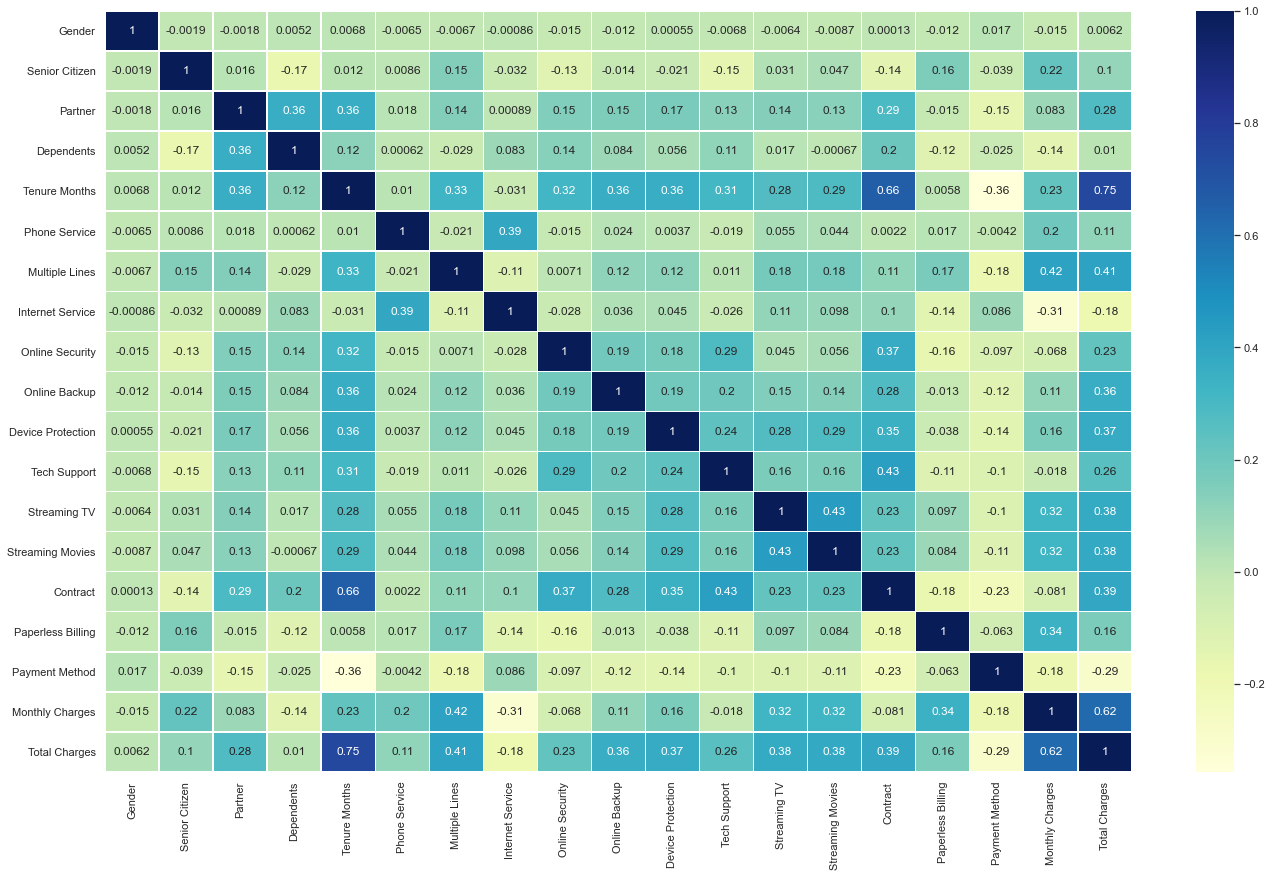

In [49]:
def object_to_int(dataframe):
    if dataframe.dtype=='object':
        dataframe = LabelEncoder().fit_transform(dataframe)
    return dataframe
df_enc = df.iloc[:,:-1].apply(lambda x: object_to_int(x))
corrmat = df_enc.corr()
f, ax = plt.subplots(figsize =(23, 14))
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.5, annot=True)
plt.show()

In [52]:
from scipy.stats import chi2_contingency
def cramers_v(x, y):
    cm = pd.crosstab(x,y)
    chi2 = chi2_contingency(cm)[0]
    n = cm.sum().sum()
    phi2 = chi2/n
    r,k = cm.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

### 2. Try Cramer's V 

In [58]:

# lst = ['Tenure Months','Monthly Charges','Total Charges','Churn Value']
lst = ['Churn Value']
df_en = df.drop(lst,axis=1)
df_encoded = df_en.apply(lambda x: object_to_int(x))

rows= []
co = df_encoded.columns.to_list()
for var1 in co:
    col = []
    for var2 in co:
        cramers = cramers_v(df_encoded[var1], df_encoded[var2]) # Cramer's V test
        col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
    rows.append(col)
cramers_results = np.array(rows)
df_corr = pd.DataFrame(cramers_results, columns = co, index =co)

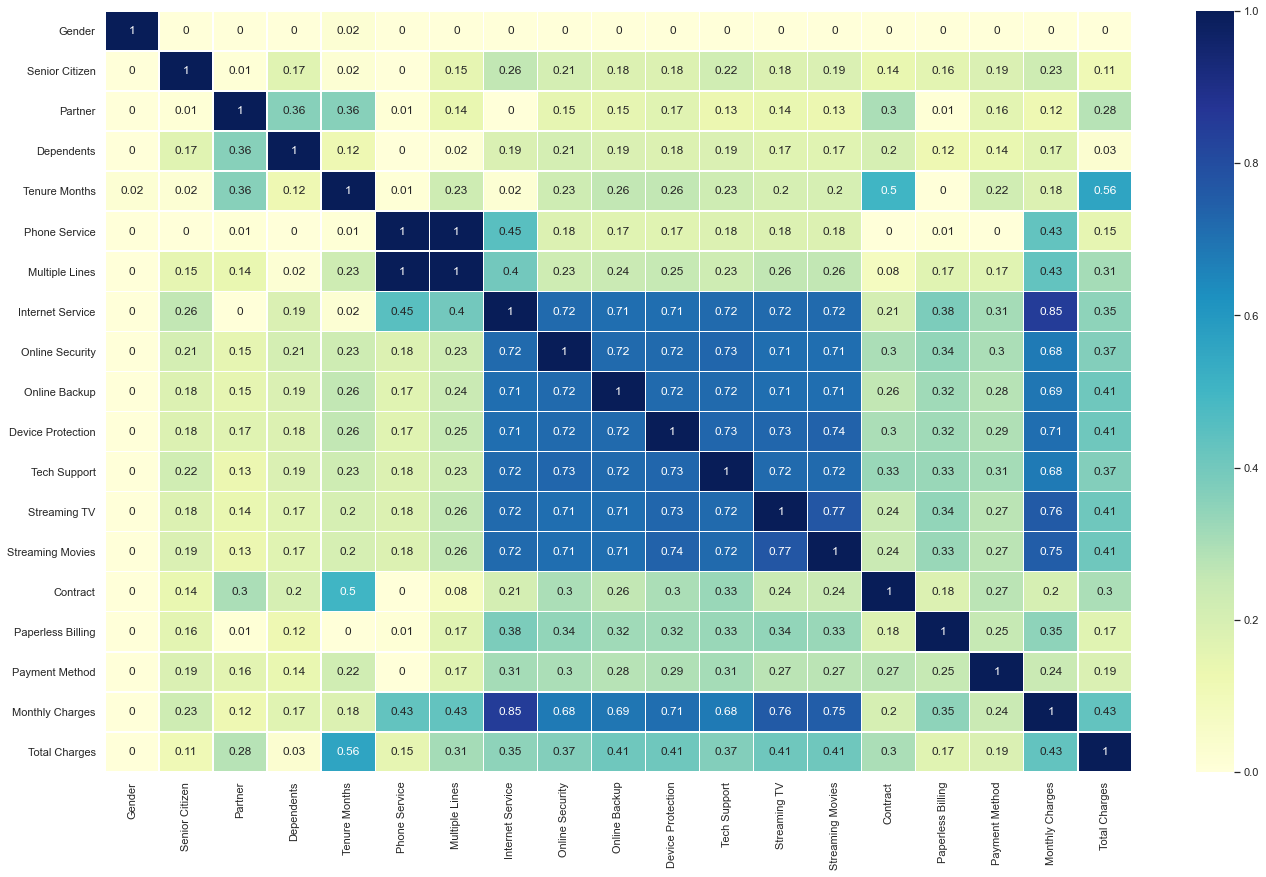

In [59]:
f, ax = plt.subplots(figsize =(23, 14))
sns.heatmap(df_corr, ax = ax, cmap ="YlGnBu", linewidths = 0.5, annot=True)
plt.show()

# Discussion the correlation
  It is clear that, for categorical data, Carmer's V makes much more sense:
  
  1. Many services are internet based and directly affected by if customers are subscribed to internet services. This is why Internet Services, Online security, Online backup ... have strong correlation. Similarly, phone sevice and Multiple lines show the same information. 
  
  2. Though Monthly Charges, Total charges, Tenure months...  the result still makes sense: Having internet means higher monthly charges.
  
  3. Tenure months is related with contract type.

# Combine correlation analysis and observation between 'churn' & 'variables'

1.drop 'gender' and 'multiple lines'

2.merge services based on internet 


In [60]:
# merge 
df.columns


Index(['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months',
       'Phone Service', 'Multiple Lines', 'Internet Service',
       'Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
       'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charges', 'Total Charges', 'Churn Value'],
      dtype='object')

In [257]:
yes_no_map = {'Yes':1,'No':0}
df['No.Internet Services'] = df.iloc[:,8:14].apply(lambda x: x.map(yes_no_map),axis =1).sum(axis =1)

In [258]:
df_new = df.drop(['Gender','Multiple Lines','Online Security','Online Backup', 'Device Protection', 'Tech Support',
       'Streaming TV', 'Streaming Movies'],axis=1)
df_new.columns

Index(['Senior Citizen', 'Partner', 'Dependents', 'Tenure Months',
       'Phone Service', 'Internet Service', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charges', 'Total Charges', 'Churn Value',
       'No.Internet Services'],
      dtype='object')

In [259]:
df_new['No.Internet Services']= df_new['No.Internet Services'].astype('int')

In [260]:
df_new.describe(include=[object]).loc['unique']

Senior Citizen       2
Partner              2
Dependents           2
Phone Service        2
Internet Service     3
Contract             3
Paperless Billing    2
Payment Method       4
Name: unique, dtype: object

# Formatting data:

In [261]:
df_new.head(5)

,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Internet Service,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value,No.Internet Services
0,No,No,No,2,Yes,DSL,Month-to-month,Yes,Mailed check,53.85,108.15,1,2
1,No,No,Yes,2,Yes,Fiber optic,Month-to-month,Yes,Electronic check,70.70,151.65,1,0
2,No,No,Yes,8,Yes,Fiber optic,Month-to-month,Yes,Electronic check,99.65,820.50,1,3
3,No,Yes,Yes,28,Yes,Fiber optic,Month-to-month,Yes,Electronic check,104.80,3046.05,1,4
4,No,No,Yes,49,Yes,Fiber optic,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,1,4


In [262]:
binary = ['Senior Citizen', 'Partner','Dependents','Phone Service','Paperless Billing']
df_new[binary] = df_new[binary].apply(lambda x: x.map(yes_no_map),axis = 1)
df_new.drop('Churn Value',axis =1, inplace = True)
X = pd.get_dummies(df_new)

In [82]:
y = df['Churn Value']

In [264]:
X_train, X_test, y_train,y_test = train_test_split(X,y,random_state = 12,stratify = y)

In [234]:
clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic', missing = None, seed = 12)
clf_xgb.fit(X_train,y_train,verbose = True,early_stopping_rounds = 10,
            eval_metric = 'aucpr',
            eval_set = [(X_test,y_test)])

[0]	validation_0-aucpr:0.66961
[1]	validation_0-aucpr:0.66603
[2]	validation_0-aucpr:0.68234
[3]	validation_0-aucpr:0.68868
[4]	validation_0-aucpr:0.68095
[5]	validation_0-aucpr:0.68283
[6]	validation_0-aucpr:0.68502
[7]	validation_0-aucpr:0.68792
[8]	validation_0-aucpr:0.68806
[9]	validation_0-aucpr:0.68984
[10]	validation_0-aucpr:0.69227
[11]	validation_0-aucpr:0.69283
[12]	validation_0-aucpr:0.69053
[13]	validation_0-aucpr:0.68957
[14]	validation_0-aucpr:0.68678
[15]	validation_0-aucpr:0.68706
[16]	validation_0-aucpr:0.68489
[17]	validation_0-aucpr:0.68571
[18]	validation_0-aucpr:0.68444
[19]	validation_0-aucpr:0.68265
[20]	validation_0-aucpr:0.68182
[21]	validation_0-aucpr:0.68322


/Users/hengzizhao/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=12,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=12,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

f1-score: 0.6236811254396247
recall 0.569593147751606
accuracy: 0.817717206132879
roc_auc: 0.7384287222529281


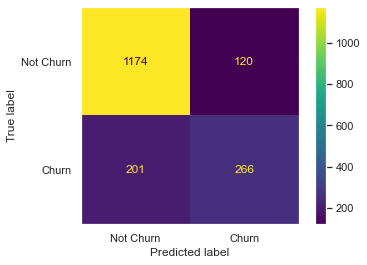

In [306]:
plot_confusion_matrix (clf_xgb, X_test, y_test, display_labels=['Not Churn', 'Churn'])
plt.grid (False)
pred = clf_xgb.predict(X_test)
print('f1-score:', f1_score(y_test,pred))
print('recall',recall_score(y_test,pred))
print('accuracy:',accuracy_score(y_test,pred))
print('roc_auc:',roc_auc_score(y_test,pred))

In [236]:
# Since optimization takes time, run it sequantially on a subset of potiential parameters.

param_grid = {'max_depth': [3,4,5],
             'learning_rate': [0.1,0.05,0.01],
             'gamma':[0,0.25,0.1],
             'reg_lambda':[0,1.0,10.0],
             'scale_pos_weight':[3]}

# Param_grid = {'max_depth': [3,4,5,6],
#              'learning_rate': [0.1,0.05,0.01,0.001],
#              'gamma':[0,0.25,0.1],
#              'reg_lambda':[0,1.0,10.0],
#              'scale_pos_weight':[1,3,5]}


# 3 - folds
# a random 90% of subset of the data 
# 70% features for each tree


optimal_param2 = GridSearchCV(estimator= xgb.XGBClassifier(objective= 'binary:logistic',
                                                         seed = 12, subsample = 0.9,
                                                         colsample_bytree = 0.7,use_label_encoder=False),
                            param_grid= param_grid,verbose= 0, n_jobs= 10, cv=3)

optimal_param2.fit(X_train, y_train, early_stopping_rounds =10, eval_metric = 'aucpr', eval_set = [(X_test,y_test)])

[0]	validation_0-aucpr:0.61145
[1]	validation_0-aucpr:0.63400
[2]	validation_0-aucpr:0.63452
[3]	validation_0-aucpr:0.63751
[4]	validation_0-aucpr:0.64466
[5]	validation_0-aucpr:0.64481
[6]	validation_0-aucpr:0.64663
[7]	validation_0-aucpr:0.64653
[8]	validation_0-aucpr:0.64586
[9]	validation_0-aucpr:0.64666
[10]	validation_0-aucpr:0.64416
[11]	validation_0-aucpr:0.64529
[12]	validation_0-aucpr:0.64572
[13]	validation_0-aucpr:0.64572
[14]	validation_0-aucpr:0.64599
[15]	validation_0-aucpr:0.64690
[16]	validation_0-aucpr:0.64783
[17]	validation_0-aucpr:0.64707
[18]	validation_0-aucpr:0.64740
[19]	validation_0-aucpr:0.64761
[20]	validation_0-aucpr:0.64737
[21]	validation_0-aucpr:0.64723
[22]	validation_0-aucpr:0.64749
[23]	validation_0-aucpr:0.64760
[24]	validation_0-aucpr:0.64761
[25]	validation_0-aucpr:0.64768
[26]	validation_0-aucpr:0.64827
[27]	validation_0-aucpr:0.64865
[28]	validation_0-aucpr:0.64806
[29]	validation_0-aucpr:0.64878
[30]	validation_0-aucpr:0.67732
[31]	validation_0-

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.7, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, seed=12,
                                     subsample=0.9, tree_metho

In [237]:
optimal_param2.best_params_

{'gamma': 0,
 'learning_rate': 0.01,
 'max_depth': 5,
 'reg_lambda': 10.0,
 'scale_pos_weight': 3}

In [320]:
clf_xgb2 = xgb.XGBClassifier(seed = 12, objective = 'binary:logistic', gamma = 0,learning_rate = 0.01,
                            max_depth = 5, scale_pos_weight = 3, reg_lambda = 10 , use_label_encoder=False,
                             subsample = 0.9,colsample_bytree = 0.5)
clf_xgb2.fit(X_train,y_train,verbose = True, early_stopping_rounds = 10,
            eval_metric = 'aucpr',
            eval_set = [(X_test,y_test)])

[0]	validation_0-aucpr:0.59207
[1]	validation_0-aucpr:0.62630
[2]	validation_0-aucpr:0.63095
[3]	validation_0-aucpr:0.63388
[4]	validation_0-aucpr:0.63956
[5]	validation_0-aucpr:0.64240
[6]	validation_0-aucpr:0.64559
[7]	validation_0-aucpr:0.64635
[8]	validation_0-aucpr:0.64776
[9]	validation_0-aucpr:0.64909
[10]	validation_0-aucpr:0.64894
[11]	validation_0-aucpr:0.65497
[12]	validation_0-aucpr:0.65586
[13]	validation_0-aucpr:0.65697
[14]	validation_0-aucpr:0.65699
[15]	validation_0-aucpr:0.65790
[16]	validation_0-aucpr:0.65720
[17]	validation_0-aucpr:0.65644
[18]	validation_0-aucpr:0.65694
[19]	validation_0-aucpr:0.65714
[20]	validation_0-aucpr:0.65623
[21]	validation_0-aucpr:0.65716
[22]	validation_0-aucpr:0.65667
[23]	validation_0-aucpr:0.65637
[24]	validation_0-aucpr:0.65656
[25]	validation_0-aucpr:0.65630


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=12,
              reg_alpha=0, reg_lambda=10, scale_pos_weight=3, seed=12,
              subsample=0.9, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

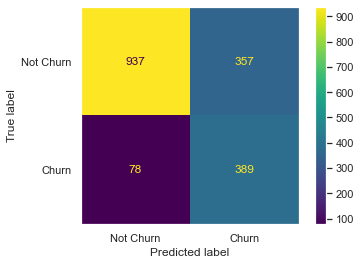

In [321]:
plot_confusion_matrix (clf_xgb2, X_test, y_test, display_labels=['Not Churn', 'Churn'])
plt.grid (False)

In [322]:
from sklearn.metrics import precision_recall_curve
pred = clf_xgb2.predict(X_test)
print('f1-score:', f1_score(y_test,pred))
print('recall',recall_score(y_test,pred))
print('roc_auc:',roc_auc_score(y_test,pred))


f1-score: 0.6413849958779885
recall 0.8329764453961456
roc_auc: 0.7785438641200203


<ipython-input-325-78c4897a168c>:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


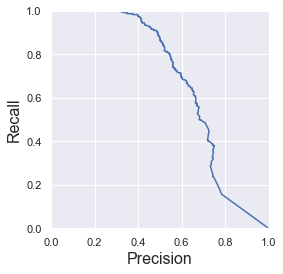

In [325]:
from sklearn.metrics import precision_recall_curve
y_prob = clf_xgb2.predict_proba(X_test)
precision,recall,thresholds = precision_recall_curve(y_test, y_prob[:,1])
closest_zero = np.argmin(np.abs(thresholds))
closest_zero_p = precision[closest_zero]
closest_zero_r = recall[closest_zero]

plt.figure()
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.plot(precision, recall, label='Precision-Recall Curve')

plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)
plt.axes().set_aspect('equal')
plt.show()

# Feature Importance of XGBoost 
Although tree-based models provide feature importances based on the mean decrease in impurity (MDI).Impurity is quantified by the splitting criterion of the decision trees (Gini, Entropy or Mean Squared Error). 

Impurity-based feature importance for trees are strongly biased and favor numerical features over binary features or categorical variables with a small number of possible categories.


In [337]:
# Rank by 'recall'

perm1 = PermutationImportance(clf_xgb2, random_state = 1,scoring ='recall',n_iter = 50).fit(X_test, y_test)
eli5.show_weights(perm1, feature_names = X_test.columns.tolist())

Weight,Feature
0.1550 ± 0.0285,Contract_Month-to-month
0.0447 ± 0.0182,Dependents
0.0371 ± 0.0119,Total Charges
0.0336 ± 0.0170,Tenure Months
0.0196 ± 0.0117,Contract_Two year
0.0147 ± 0.0076,Contract_One year
0.0113 ± 0.0144,Internet Service_Fiber optic
0.0102 ± 0.0144,Monthly Charges
0.0066 ± 0.0048,Partner
0.0047 ± 0.0079,Internet Service_DSL


In [338]:
# Rank by 'f1'

perm1 = PermutationImportance(clf_xgb2, random_state = 1,scoring ='f1',n_iter = 50).fit(X_test, y_test)
eli5.show_weights(perm1, feature_names = X_test.columns.tolist())

Weight,Feature
0.0531 ± 0.0222,Contract_Month-to-month
0.0264 ± 0.0130,Dependents
0.0087 ± 0.0118,Tenure Months
0.0079 ± 0.0097,Total Charges
0.0050 ± 0.0086,Internet Service_Fiber optic
0.0050 ± 0.0071,Internet Service_No
0.0037 ± 0.0039,Partner
0.0016 ± 0.0031,Payment Method_Credit card (automatic)
0.0014 ± 0.0079,Contract_Two year
0.0008 ± 0.0015,Paperless Billing


# Summary
Although more feature engineering doesn't help to improve the performance, but the number of features is reduced from 46 to 19, which means much less computing cost result very similar performance. For real-world problem, the number of features can be thousands or tens of thousands, then the benefit of reducing computing cost will be more significant.

## RandomForest

In [244]:
rf = RandomForestClassifier(random_state=12)

param_grid = {'n_estimators':[500,1000],
             'max_depth':[4,5,6],
             'bootstrap':[True], 'class_weight':[{1:w} for w in [1,2,3]] }

rfclf = GridSearchCV(rf,param_grid= param_grid,scoring = 'recall', cv=3)
rfclf.fit(X_train,y_train)


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=12),
             param_grid={'bootstrap': [True],
                         'class_weight': [{1: 1}, {1: 2}, {1: 3}],
                         'max_depth': [4, 5, 6], 'n_estimators': [500, 1000]},
             scoring='recall')

In [245]:
rfclf.best_params_

{'bootstrap': True,
 'class_weight': {1: 3},
 'max_depth': 4,
 'n_estimators': 500}

In [246]:
pred = rfclf.predict(X_test)
print('f1-score:', f1_score(y_test,pred))
print('recall',recall_score(y_test,pred))
print('roc_auc:',roc_auc_score(y_test,pred))
#print('accuracy_score:',accuracy_score(y_test,pred))

f1-score: 0.6384039900249375
recall 0.8222698072805139
roc_auc: 0.7751225388798242


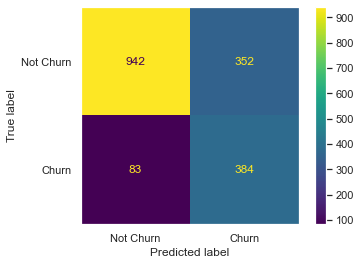

In [247]:
plot_confusion_matrix (rfclf, X_test, y_test, display_labels=['Not Churn', 'Churn'])
plt.grid (False)



# Try other models after upsampling.


Imagine the simplest method of upsampling. Let's say every data point is "copied" 6 times. It isn't hard to imagine that in 3-fold validation, a typical folding has (on average) 2 copies of each point in each fold. If the classifier memories the test set, the validation set will get a perfect score because the validation set has no new data points! I made this mistakes before.

Instead, we should split into training and validation folds. Then, on each fold, we should upsample the minority class

Train the classifier on the training folds

Validate the classifier on the remaining fold

In [268]:
from imblearn.over_sampling import SMOTE


f1 LogReg: 0.632907 (+/- 0.016756)
f1 SVC: 0.616965 (+/- 0.022783)
f1 KNN: 0.572882 (+/- 0.010275)
f1 GradientBoostingClassifier: 0.584197 (+/- 0.028393)
f1 RidgeClassifier: 0.629760 (+/- 0.011652)


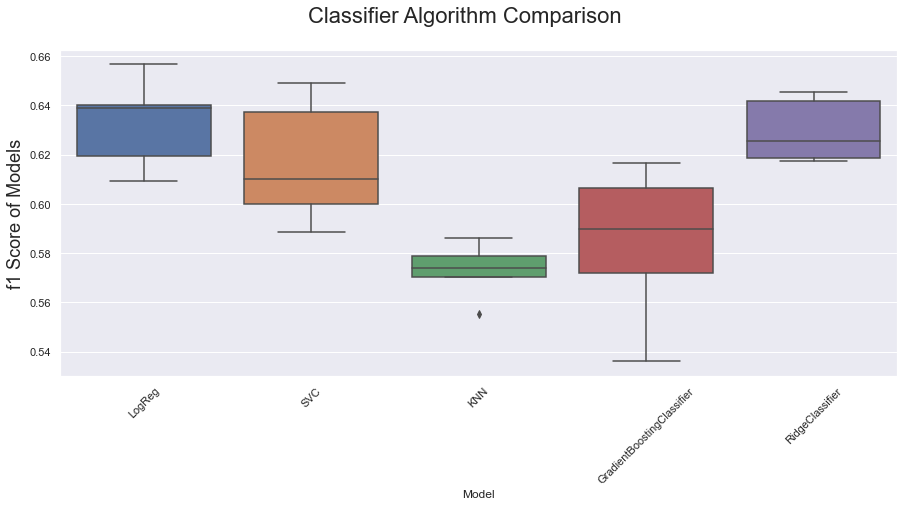

In [305]:
# pipeline for a simple experiment

clfs = []


clfs.append(("LogReg", 
             Pipeline([("Scaler", StandardScaler()),
                       ("LogReg", LogisticRegression())])))

clfs.append(("SVC", 
             Pipeline([("Scaler", StandardScaler()),
                       ("SVC", SVC(kernel = 'rbf', class_weight= 'balanced'))]))) 
clfs.append(("KNN", 
             Pipeline([("Scaler", StandardScaler()),
                       ("KNN", KNeighborsClassifier())]))) 

clfs.append(("GradientBoostingClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("GradientBoosting", GradientBoostingClassifier(max_features=15, 
                                                                       n_estimators=1000))]))) 

clfs.append(("RidgeClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("RidgeClassifier", RidgeClassifier())])))


# Using F1 score 
scoring = 'f1'

n_folds = 5

results, names  = [], [] 

for name, model  in clfs:
    
    
    # upsampling for training datasets
    
    cv = KFold(n_splits=n_folds, shuffle= True)

    smoter = SMOTE(random_state = 12)
    scores = []
    for train_fold_index, val_fold_index in cv.split(X_train, y_train):

        X_train_fold, y_train_fold = X_train.iloc[train_fold_index], y_train.iloc[train_fold_index]
        X_val_fold, y_val_fold = X_train.iloc[val_fold_index], y_train.iloc[val_fold_index]

        X_train_fold_upsample, y_train_fold_upsample = smoter.fit_resample(X_train_fold,
                                                                           y_train_fold)


        model_obj = model.fit(X_train_fold_upsample, y_train_fold_upsample) 

        score = f1_score(y_val_fold, model_obj.predict(X_val_fold))
        scores.append(score)
        
    names.append(name)
    results.append(scores)    
    msg = "%s %s: %f (+/- %f)" % (scoring,name, np.mean(scores),np.std(scores))
    print(msg)

# I should improve the code for visualisation 
Score = np.array(results).ravel()
nn = [[i] * 5 for i in names]
nn = np.array(nn).ravel().tolist()
df_re = pd.DataFrame([nn,Score]).T
df_re.columns = ['Model','Score']

# boxplot algorithm comparison
fig = plt.figure(figsize=(15,6))
fig.suptitle('Classifier Algorithm Comparison', fontsize=22)
ax = fig.add_subplot(111)
sns.boxplot(x='Model', y='Score',data= df_re)
ax.set_xticklabels(names)
ax.set_ylabel("{} Score of Models".format(scoring), fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

plt.show()

Although just a simple experiment, it looks like there are some models having promising results.

For further experimentation I could explore optimizing the models above. I could also look at adding other factors in, such as if location (city) is correlated to churn, although one-hot-encoding city didn't make much difference to predictions. Maybe alternatively, clustering could be looked at?